# Generate training data for exercises
 >__Created__:  2020 Harrison B. Prosper


### Using Google Drive in Google Colab
It is often convenient to have access to Google Drive when this notebook is run in Google Colab. In order to gain access to Google Drive from the notebook do the following:
  1. Place this notebook in a folder on Google Drive. Click on the notebook and choose to open it with Google Colab.
  1. Once the notebook is running in Google Colab, uncomment and execute the cell below and follow the authentication instructions.
  1. To use hardware acceleration select the menu item $\color{blue}{\textrm{Runtime/Change runtime type}}$ and select GPU.



In [2]:
#from google.colab import drive 
#drive.mount('/content/gdrive') 

BASE should contain the folder in which you wish to save files (here called *colab_notebooks*).

In [3]:
#BASE = '/content/gdrive/My Drive/colab_notebooks'
BASE = './' 

### Standard imports

In [4]:
import os, sys
import numpy as np
import joblib as jb
import scipy.stats as st 
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
%matplotlib inline

### Set up fonts

In [5]:
FONTSIZE = 14
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)
mp.rc('xtick', labelsize='x-small')
mp.rc('ytick', labelsize='x-small')

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

# uncomment if you have access to a full Latex installation and you
# want high-quality fonts.
#mp.rc('text', usetex=True)

### Data: 01_classification.ipynb

In [6]:
%%writefile cprob.py
import numpy as np
import scipy.stats as st

STDV   = 0.5
NDATA  = 15000

# t = 0
MU00   = np.array([-1.0, 1.0])
COV00  = np.array([[STDV, 0.0],
                   [ 0.0, STDV]])

MU01   = np.array([1.0, -1.0])
COV01  = np.array([[STDV, 0.0],
                   [ 0.0, STDV]])

# t = 1
MU10   = np.array([-1.0, -1.0])
COV10  = np.array([[STDV, 0.0],
                   [ 0.0, STDV]])

MU11   = np.array([1.0, 1.0])
COV11  = np.array([[STDV, 0.0],
                   [ 0.0, STDV]])

# t = 0 
# density
def px0(x):
    p \
    = st.multivariate_normal.pdf(x, MU00, COV00) \
    + st.multivariate_normal.pdf(x, MU01, COV01)
    return p / 2

# data generation
def generate0():
    xy = st.multivariate_normal.rvs(MU00, COV00, NDATA).tolist()
    z  = st.multivariate_normal.rvs(MU01, COV01, NDATA).tolist()
    xy.extend(z)
    return np.array(xy)

# t = 1 
# density
def px1(x):
    p \
    = st.multivariate_normal.pdf(x, MU10, COV10) \
    + st.multivariate_normal.pdf(x, MU11, COV11)
    return p / 2

# data generation
def generate1():
    xy = st.multivariate_normal.rvs(MU10, COV10, NDATA).tolist()
    z  = st.multivariate_normal.rvs(MU11, COV11, NDATA).tolist()
    xy.extend(z)
    return np.array(xy)

# p(1|x)
def p1x(x):
    return px1(x) / ( px1(x) + px0(x) )

Overwriting cprob.py


In [7]:
import cprob as cp

Generate a balanced data set: $p(0) = p(1)$
  1. Generate data for $t = 0$
  1. Generate data for $t = 1$
  1. Concatenate data sets
  1. Randomly shuffle rows
  1. Write out data set

In [8]:
def generate(target):
    d  = cp.generate0() if target < 0.5 else cp.generate1()
    N  = len(d)
    T  = np.zeros(N) if target < 0.5 else np.ones(N)
    X  = [x for x, y in d]
    Y  = [y for x, y in d]
    df = pd.DataFrame({'target': T, 'x': X, 'y': Y})
    return df

In [10]:
b = generate(0)
s = generate(1)
d = b.append(s)

# frac=1 => all rows
# reset_index(drop=True) => drop original indices and create new ones
d = d.sample(frac=1).reset_index(drop=True)

# save data
jb.dump(d, '%s/data_01.db' % BASE)
d[:5]

,target,x,y
0,1.0,2.095157,1.331402
1,1.0,-1.373910,-1.460193
2,1.0,-0.070309,0.304780
3,0.0,-1.422918,1.710533
4,0.0,0.115399,-0.888842


In [11]:
def plot_data_1(df, N=8000):
    sig = df[df.target > 0.5][:N]
    bkg = df[df.target < 0.5][:N]
    
    # create an empty figure
    fig = plt.figure(figsize=(5, 5))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)
    ax.set_xlabel('$x$', fontsize=FONTSIZE)
    ax.set_ylabel('$y$', fontsize=FONTSIZE)
    ax.set_xlim([-4, 4])
    ax.set_ylim([-4, 4])
    ax.scatter(sig['x'], sig['y'], c='b', s=1, alpha=0.5, label='$t = 1$')
    ax.scatter(bkg['x'], bkg['y'], c='r', s=1, alpha=0.5, label='$t = 0$')

    ax.grid(True, which="both", linestyle='-')
    ax.legend(loc='upper right')

    plt.show()

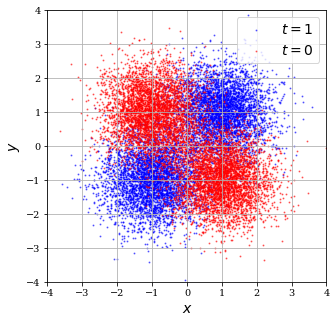

In [12]:
plot_data_1(d)

### Data: 02_regression.ipynb

In [13]:
N  = 60000
x  = np.random.uniform(-1, 1, N)

# targets
t = 3 * np.exp(-x/2) * np.sin(10*x)**2 + 2*np.cos(6*x) - 1.5

In [14]:
df = pd.DataFrame({'target': t, 'x': x})
jb.dump(df, '%s/data_02.db' % BASE)
df[:5]

,target,x
0,-3.105740,0.629966
1,-0.286466,0.246750
2,-2.917715,0.581079
3,0.419841,0.859817
4,0.526352,0.847580


In [15]:
def plot_1d(x, t):
    
    # create an empty figure
    fig = plt.figure(figsize=(5, 5))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)
    ax.scatter(x, t, c='b', s=5)
    ax.set_xlabel('$x$', fontsize=FONTSIZE)
    ax.set_ylabel('$t$', fontsize=FONTSIZE)
    ax.set_xlim([-1, 1])
    ax.set_ylim([-4, 4])
    ax.grid(True, which="both", linestyle='-')
    plt.show()

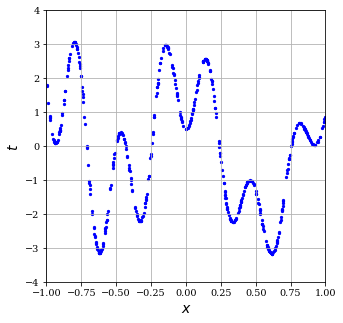

In [16]:
M = 500
plot_1d(x[:M], t[:M])

### Data: 03_likelihood.ipynb
We shall generate data using the generalized gamma density, defined by
\begin{align}
    p(x | a, c) & = |c| \frac{x^{ca - 1} \exp(-x^c)}{\Gamma(a)} .
\end{align}

In a real application, the data would be the result of a stochastic simulation in which the density is unknown or intractable.


#### Generation of simulated data
The basic procedure is the same for all simulations:
  1. Sample a parameter point from a known density: $\theta_m \sim p(\theta | 1)$.
  1. Simulate $x_m$ given $\theta_m$.
  1. Repeat 1 and 2 $N$ times.
Generally, $p(\theta | 1)$ is chosen so that it is easy and fast to sample from and so that the generated sample $\{ \theta_m \}$ has good space-filling properties in the relevant subset of the parameter space. 

Here, we have choosen $p(\theta | 1)$ to be a uniform density in a 2D square parameter subspace. But a uniform density is not necessarily the best choice in a high-dimensional parameter space. Consider the volume enclosed by an $n$-dimensional box of side $2R$ that encloses an $n$-dimensional sphere or radius $R$. The ratio of the volume of the box to that of the sphere is

\begin{align}
  r & = \frac{(2R)^n}{\pi^{n/2} R^n \, / \, \Gamma(n/2 + 1)}, \\
  & = 2^n \Gamma(n/2 + 1) \, / \, \pi^{n/2}, \\
  & \approx 2^n \left(\frac{n}{2\pi e}\right)^{n/2}, 
\end{align}

which shows that for $n >> 2$, most of the volume of the box is squeezed into its corners. Consequently, a uniform density over the box may not necessariy place parameter points where they are needed most, which is in the *support* of the likelihood when the latter is viewed as a function of its parameters. But this presents a "chicken and egg" problem: in order to know where to place the parameter points, we need to have some idea of the support of the likelihood, which requires some knowledge of the likelihood!

This is not quite as hopeless as it might seem. We could use a simple fitting procedure, e.g., least squares, in order to arrive at the approximate location of the mode of the likelihood. Given a rough idea of the mode, we can at least ensure that we sample about the mode.


  1. __Data associated with target__ $t = 1$
     1. Generate $N$ sets of parameters $\theta = a, c$ uniformly in the space $(0.1, 5.0) \otimes  (0.1, 5.0)$. 
     1. For each parameter point $\theta_m = a_m, c_m$ generate a single datum $x_m$ using 
    \begin{align}
    p(x | a_m, c_m) & = |c_m| \frac{x^{c_m a_m - 1} \exp(-x^{c_m})}{\Gamma(a_m)} .
    \end{align}
     1. Assign $t = 1$ to these data: $\{ \color{blue}{(1, x_m, a_m, c_m)}, m = 1,\cdots,N \}$. <p>
  1. __Data associated with target__ $t = 0$
     1. Generate $N$ sets of parameters as for $t = 1$.
     1. Generate $N$ values $\{ x_m, m = 1,\cdots,N \}$ uniformly in the space $(0.0, 10.0)$
     1. Assign $t = 0$ to these data: $\{ \color{red}{(0, x_m, a_m, c_m)}, m = 1,\cdots,N \}$.
  1. Concatenate the two data sets into a single table and randomly shuffle the rows.

In [17]:
def plot_gengamma(a, c, xmin=0, xmax=5, xstep=0.01):
  
    # create an empty figure
    fig = plt.figure(figsize=(5, 4))
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    
    ax = fig.add_subplot(nrows,ncols,index)
    ax.set_xlabel('$x$', fontsize=FONTSIZE)
    ax.set_ylabel('$p(x|a, c)$', fontsize=FONTSIZE)
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([0.0, 3.0])
    
    x  = np.arange(xmin, xmax+xstep, xstep)
    kolor = ['red', 'orange', 'yellow', 
             'green', 'blue', 'indigo', 'violet']
    i = 0
    for ai, ci in zip(a, c):
        y = st.gengamma.pdf(x, ai, ci)
        ax.plot(x, y, color=kolor[i])
        i += 1
        if i >= len(kolor):
            i = 0
    fig.tight_layout()
    plt.show()

In [18]:
def plot_data_2(df, N=8000, nbins=25, limits=(0, 5)):
    
    # divide data into 
    # those with target == 1 and 
    # those with target == 0.
    sig = df[df.target > 0.5]
    bkg = df[df.target < 0.5]
    if len(sig) > N:
        sig = sig[:N]
    if len(bkg) > N:
        bkg = bkg[:N]
    
    # create an empty figure
    fig = plt.figure(figsize=(5, 5))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)
    ax.set_xlabel('$x$', fontsize=FONTSIZE)
    ax.set_ylabel('$y$', fontsize=FONTSIZE)
    ax.set_xlim(limits)
    
    if len(sig) > 0:
        ax.hist(sig.x, bins=nbins, range=limits,
                color='b', alpha=0.3, label='$t = 1$')
    
    if len(bkg) > 0:
        ax.hist(bkg.x, bins=nbins, range=limits,
                color='r', alpha=0.3, label='$t = 0$')
        
    ax.grid(True, which="both", linestyle='-')
    ax.legend(loc='upper right')

    plt.show()

#### Generate $t = 1$ data

50000


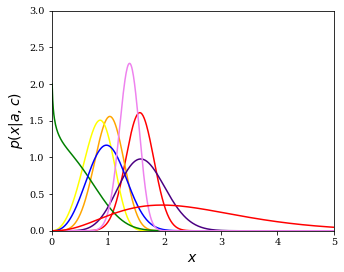

In [19]:
N    = 60000

xmin = 0.0
xmax =10.0

amin = 0.1
amax = 5.0

cmin = 0.1
cmax = 5.0

a = rnd.uniform(amin, amax, N)
c = rnd.uniform(cmin, cmax, N)
x = st.gengamma.rvs(a, c, size=N)
t = np.ones(N)

keep = (x > xmin) & (x < xmax)

N = 50000

a = a[keep][:N]
c = c[keep][:N]
x = x[keep][:N]
t = t[keep][:N]

sf= pd.DataFrame({'target': t, 'x': x, 'a': a, 'c': c})
print(len(sf))
plot_gengamma(a[:8], c[:8])

#### Generate $t = 0$ data

In [20]:
N = 50000
a = rnd.uniform(amin, amax, N)
c = rnd.uniform(cmin, cmax, N)
x = rnd.uniform(xmin, xmax, N)
t = np.zeros(N)

bf= pd.DataFrame({'target': t, 'x': x, 'a': a, 'c': c})

100000


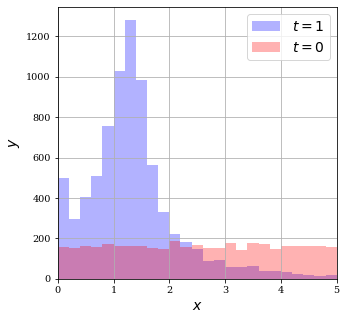

In [21]:
# append t=0 data to t=1 data
data = sf.append(bf)

# frac=1 => use all rows
# reset_index(drop=True) => drop original indices and create new ones
data = data.sample(frac=1).reset_index(drop=True)

# save data
jb.dump(data, '%s/data_03.db' % BASE)
print(len(data))

plot_data_2(data)